In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, StrMethodFormatter


In [2]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [3]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [4]:
def keep_totals_slice(df, filters):
    """
    Filters a DataFrame by multiple equality conditions passed as keyword args.
    Example:
        keep_totals_slice(df,
            {
                "CAH level marker": "CAH level 3",
                "Level of study": "All",
                "Mode of study": "All",
                "Category marker": "Sex",
                "Category": "Female"
            }
        )
    """
    mask = pd.Series(True, index=df.index)
    for col, value in filters.items():
        mask &= df[col].eq(value)
    return df.loc[mask].copy()


In [5]:
def filter_scope(d, custom=("10", "11", "13")):
    keep = d["CAH level subject"].str.startswith(custom, na=False)
    df_keep = d[keep].copy()
    return df_keep

In [6]:
def ensure_subject_label_has_no_code(d):
    if "Subject" not in d.columns:
        d["Subject"] = d["CAH level subject"].str.replace(
            r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True
        ).str.strip()
    return d

In [7]:
def build_pivot(d):
    pvt = d.pivot_table(index="Academic Year", columns="Subject",
                        values="Number", aggfunc="sum").fillna(0)
    order = (pvt.index.str.slice(0, 4).astype(int)).argsort()
    pvt = pvt.iloc[order]
    return pvt

In [8]:
hesa_csv_path = r"../data/item-9"

In [9]:
slice = {
    "CAH level marker": "CAH level 1",
    "CAH level subject": "10 Engineering and technology",
    "Level of study": "All",
    "Mode of study": "All",
    "Age group": "Total",
}

df = load_df(hesa_csv_path, skip_rows=22)
df_hesa_clean = keep_totals_slice(df, slice)

In [10]:
df_hesa_clean.head(20)

,CAH level marker,CAH level subject,Level of study,Mode of study,Academic Year,Age group,Number
10097,CAH level 1,10 Engineering and technology,All,All,2014/15,Total,163405
10115,CAH level 1,10 Engineering and technology,All,All,2015/16,Total,165330
10133,CAH level 1,10 Engineering and technology,All,All,2016/17,Total,167415
10151,CAH level 1,10 Engineering and technology,All,All,2017/18,Total,167570
10169,CAH level 1,10 Engineering and technology,All,All,2018/19,Total,167805
10187,CAH level 1,10 Engineering and technology,All,All,2019/20,Total,175255
10205,CAH level 1,10 Engineering and technology,All,All,2020/21,Total,183165
10223,CAH level 1,10 Engineering and technology,All,All,2021/22,Total,185725
10241,CAH level 1,10 Engineering and technology,All,All,2022/23,Total,185830
10259,CAH level 1,10 Engineering and technology,All,All,2023/24,Total,179015


In [11]:
occ_csv_path= r"../data/occ"
df_occ_clean = load_df(occ_csv_path, skip_rows=0)

df_occ_clean.head(20)

,Levels (000s),2015,2019,2020,2025,2035,Net Change,Replacement Demand,Total Requirement
0,11 Corporate managers and directors,2147.971324,2544.407261,2603.614963,2446.57316,2681.277535,77.662571,1300.089797,1377.752368
1,12 Other managers and proprietors,1057.453815,1133.318275,1142.944239,1416.071102,1636.971336,494.027097,824.2093,1318.236397
2,"21 Science, research, engineering and technolo...",1804.444433,2078.603546,2168.489398,2306.730078,2562.982823,394.493425,893.913441,1288.406866
3,22 Health professionals,1431.70475,1645.52271,1652.689484,1790.213386,1962.777974,310.08849,973.656518,1283.745008
4,23 Teaching and other educational professionals,1646.97869,1740.72735,1814.394992,1909.772018,2082.025478,267.630486,993.762117,1261.392603
5,"24 Business, media and public service professi...",2002.353972,2371.580392,2564.005836,2881.779195,3234.030805,670.024969,1418.860773,2088.885743
6,"31 Science, engineering and technology associa...",543.134113,639.969847,694.160226,615.489876,660.154719,-34.005507,261.710673,227.705166
7,32 Health and social care associate professionals,594.94855,665.160598,684.346708,696.565418,766.023624,81.676915,410.783787,492.460703
8,33 Protective service occupations,363.346729,374.450165,396.952404,471.172411,540.740771,143.788367,168.788028,312.576395
9,"34 Culture, media and sports occupations",690.993981,706.287727,752.69702,748.061749,831.237661,78.540641,363.121743,441.662384


In [12]:
def _to_num(x):
    return pd.to_numeric(str(x).strip().replace(",", ""), errors="coerce")

def _acad_to_end_year(s: str) -> int:
    s = str(s).strip()
    m = re.search(r"(20|19)\d{2}\s*/\s*(\d{2})", s)
    if m:
        start = int(s[:4])
        return start + 1  # "2014/15" -> 2015
    m2 = re.search(r"(20|19)\d{2}", s)
    return int(m2.group(0)) if m2 else np.nan

In [13]:
def build_engineering_demand_from_occ_clean(
    df_occ_clean: pd.DataFrame,
    focus_socs=("21", "31"),
    annualize_years=16,     # 2020–2035 inclusive → 16 steps; change to 15 if preferred
    positive_net_only=True, # count only positive net change as openings
    out_years=range(2024, 2031)
) -> pd.DataFrame:
    """
    Expects columns:
      'Levels (000s)','2020','2025','2035','Net Change','Replacement Demand','Total Requirement'
    Returns: Year, Demand (thousands) for the requested out_years.
    """
    d = df_occ_clean.copy()
    d.columns = [str(c).strip() for c in d.columns]

    # Robust SOC extraction (named capture to satisfy pyarrow backend)
    soc_extracted = (
        d["Levels (000s)"]
        .astype(str)
        .str.extract(r'^(?P<SOC>\d{2})', expand=True)
    )
    d["_SOC"] = soc_extracted["SOC"]

    # Keep only wanted SOCs (and drop rows without a SOC code)
    d = d[d["_SOC"].isin(list(focus_socs))].copy()

    # Coerce numerics
    for col in ["2020", "2025", "2035", "Net Change", "Replacement Demand", "Total Requirement"]:
        if col in d.columns:
            d[col] = pd.to_numeric(
                d[col].astype(str).str.replace(",", "", regex=False).str.strip(),
                errors="coerce"
            )

    years = np.arange(2020, 2035 + 1)
    rows = []

    for _, r in d.iterrows():
        rep_total = float(r.get("Replacement Demand", 0.0))
        rep_per_year = rep_total / annualize_years if annualize_years > 0 else 0.0

        emp2020 = float(r.get("2020", np.nan))
        emp2025 = float(r.get("2025", np.nan))
        emp2035 = float(r.get("2035", np.nan))

        # Build piecewise-linear employment path 2020→2025 and 2025→2035
        emp = {}
        for y in range(2020, 2025 + 1):
            t = (y - 2020) / 5.0
            emp[y] = emp2020 + t * (emp2025 - emp2020)
        for y in range(2025, 2035 + 1):
            t = (y - 2025) / 10.0
            emp[y] = emp2025 + t * (emp2035 - emp2025)

        # Annual net change; openings = replacement + (positive part of net change by default)
        for y in years:
            prev = y - 1
            nc = (emp[y] - emp[prev]) if prev in emp else 0.0
            if positive_net_only:
                nc = max(nc, 0.0)
            openings = rep_per_year + nc
            rows.append({"Year": y, "SOC": r["_SOC"], "Openings": openings})

    eng = (pd.DataFrame(rows)
           .groupby("Year", as_index=False)["Openings"].sum()
           .rename(columns={"Openings": "Demand"}))

    # Restrict to requested window
    eng = eng[eng["Year"].isin(out_years)].reset_index(drop=True)
    return eng


In [14]:
def build_supply_from_hesa_clean(
    df_hesa_clean: pd.DataFrame,
    out_years=range(2024, 2031),
    proj_method="flat"   # "flat" or "cagr"
) -> pd.DataFrame:
    """
    Expects your HESA table with columns:
      'CAH level subject','Level of study','Mode of study','Academic Year','Age group','Number'
    Filters to: Engineering & technology / All / All / Total.
    Returns Year, Supply (thousands) incl. simple projections for out_years beyond last actual.
    """
    d = df_hesa_clean.copy()
    d.columns = [str(c).strip() for c in d.columns]

    d = d[
        (d["CAH level subject"].astype(str).str.strip() == "10 Engineering and technology") &
        (d["Level of study"].astype(str).str.strip() == "All") &
        (d["Mode of study"].astype(str).str.strip() == "All") &
        (d["Age group"].astype(str).str.strip() == "Total")
    ].copy()

    d["Number"] = d["Number"].apply(_to_num)
    d["Year"] = d["Academic Year"].apply(_acad_to_end_year)
    d = d.dropna(subset=["Year"]).copy()
    d["Year"] = d["Year"].astype(int)

    base = (d.groupby("Year", as_index=False)["Number"].sum()
              .rename(columns={"Number": "Supply"}))
    base["Supply"] = base["Supply"] / 1_000.0  # to thousands

    # Project to requested out_years if needed
    last_actual_year = base["Year"].max()
    last_val = float(base.loc[base["Year"] == last_actual_year, "Supply"].iloc[0])

    if proj_method == "cagr":
        y0 = base["Year"].min()
        v0 = float(base.loc[base["Year"] == y0, "Supply"].iloc[0])
        n = last_actual_year - y0
        cagr = (last_val / v0) ** (1 / n) - 1 if (n > 0 and v0 > 0) else 0.0
        proj = []
        for y in out_years:
            if y <= last_actual_year: 
                continue
            t = y - last_actual_year
            proj.append({"Year": y, "Supply": last_val * ((1 + cagr) ** t)})
        proj = pd.DataFrame(proj)
    else:
        proj = pd.DataFrame(
            [{"Year": y, "Supply": last_val} for y in out_years if y > last_actual_year]
        )

    out = (pd.concat([base, proj], ignore_index=True)
             .drop_duplicates(subset=["Year"])
             .sort_values("Year"))
    # Keep requested window
    out = out[out["Year"].isin(out_years)].reset_index(drop=True)
    return out  # thousands

In [15]:
def plot_demand_vs_supply_simple(
    df_demand, df_supply,
    title="Projected Engineering Job Openings vs Graduate Supply (2024–2030)",
    ylabel="People (thousands)",
    out_basename="chart9_demand_vs_supply",
    chart_dir="chart-9",
    kind="line"
):
    years = sorted(set(df_demand["Year"]).union(df_supply["Year"]))
    m = pd.DataFrame({"Year": years}).merge(df_demand, on="Year", how="left") \
                                     .merge(df_supply, on="Year", how="left")
    m = m[(m["Year"] >= 2024) & (m["Year"] <= 2030)].copy()

    nx = len(m)
    fig_w = max(14, min(26, 1.3 * nx))
    fig, ax = plt.subplots(figsize=(fig_w, 6))

    if kind == "area":
        ax.fill_between(m["Year"], m["Demand"], alpha=0.35, label="Projected openings (demand)")
        ax.fill_between(m["Year"], m["Supply"], alpha=0.35, label="Graduates (supply)")
        ax.plot(m["Year"], m["Demand"], lw=1.8)
        ax.plot(m["Year"], m["Supply"], lw=1.8)
    else:
        ax.plot(m["Year"], m["Demand"], lw=2.2, label="Projected openings (demand)")
        ax.plot(m["Year"], m["Supply"], lw=2.2, label="Graduates (supply)")

    # Shade shortage where Demand > Supply
    if {"Demand", "Supply"}.issubset(m.columns):
        ax.fill_between(m["Year"], m["Supply"], m["Demand"],
                        where=(m["Demand"] > m["Supply"]),
                        interpolate=True, alpha=0.15)

    ax.set_title(title, pad=12, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)

    ax.xaxis.set_major_locator(FixedLocator(m["Year"].values))
    ax.xaxis.set_major_formatter(FixedFormatter([str(y) for y in m["Year"]]))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.grid(True, axis="x", linestyle=":", alpha=0.25)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, ncol=1)
    plt.tight_layout()

    # Use your existing helper
    try:
        from utils.common_functions import save_or_show
        save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)
    except Exception:
        plt.show()

In [16]:
# years_window = range(2024, 2031)

# df_demand = build_engineering_demand_from_occ_clean(
#     df_occ_clean,
#     focus_socs=("21","31"),     # add "52" if you want skilled trades included
#     annualize_years=16,         # 2020–2035 inclusive; set 15 if your convention differs
#     positive_net_only=True,
#     out_years=years_window
# )

# df_supply = build_supply_from_hesa_clean(
#     df_hesa_clean,
#     out_years=years_window,
#     proj_method="flat"          # or "cagr"
# )

# plot_demand_vs_supply_simple(
#     df_demand, df_supply,
#     title="Projected Engineering Job Openings vs Graduate Supply (2024–2030)",
#     out_basename="chart9_demand_vs_supply",
#     chart_dir="chart-9",
#     kind="line"                 # or "area"
# )

In [17]:
# df = df_occ_clean.copy()

# def plot_demand_vs_requirement_bar(df, show_codes=None, out_dir="chart-9", out_basename="chart9_demand_vs_total"):
#     # Load and clean data
#     df = df
#     df.columns = [c.strip() for c in df.columns]
#     df.rename(columns={df.columns[0]: "Occupation"}, inplace=True)
    
#     # Extract code and name
#     code_pattern = r"^(?P<Code>\d{2})\s+(?P<CleanName>.+)$"
#     df[["Code", "CleanName"]] = df["Occupation"].str.extract(code_pattern)
#     df["Code"] = df["Code"].astype(str)
    
#     # Filter if codes provided
#     if show_codes:
#         df = df[df["Code"].isin(show_codes)]
    
#     # Drop NA and sort
#     df_plot = df[["CleanName", "Replacement Demand", "Total Requirement"]].dropna()
#     df_plot = df_plot.sort_values("Total Requirement", ascending=True)
    
#     # Plot
#     # fig, ax = plt.subplots(figsize=(10, 12))
#     fig, ax = plt.subplots(figsize=(9, max(3.2, min(10.0, 0.48 * len(df_plot) + 1.0))))
#     y = range(len(df_plot))
    
#     ax.barh(y, df_plot["Replacement Demand"], color="#74a3cf", label="Replacement Demand")
#     ax.barh(y, df_plot["Total Requirement"], color="#0570b0", alpha=0.85, label="Total Requirement")
    
#     ax.set_yticks(y)
#     ax.set_yticklabels(df_plot["CleanName"])
#     ax.set_xlabel("Thousands of Jobs (2020–2035)")
#     ax.set_title("Projected Job Openings: Replacement Demand vs Total Requirement 2035", fontsize=13, weight="bold")
#     ax.legend()
    
#     plt.tight_layout()
#     save_or_show(fig, out_dir=out_dir, filename=out_basename, show=True)



# # def plot_selected_occupations(df, selected_codes, out_dir="chart-9", filename="job_openings_by_occupation"):
# #     df = df.copy()
    
# #     # Extract numeric code and occupation name
# #     df[["Code", "Occupation"]] = df["Levels (000s)"].str.extract(r"^(\d{2})\s+(.*)")
# #     df["Code"] = df["Code"].astype(str)
    
# #     # Filter based on selected occupation codes
# #     df_plot = df[df["Code"].isin(selected_codes)].copy()
    
# #     # Convert values to numeric
# #     df_plot["Replacement Demand"] = pd.to_numeric(df_plot["Replacement Demand"], errors="coerce")
# #     df_plot["Total Requirement"] = pd.to_numeric(df_plot["Total Requirement"], errors="coerce")
    
# #     df_plot = df_plot.sort_values("Total Requirement", ascending=True)

# #     # Plot
# #     fig, ax = plt.subplots(figsize=(10, 12))
# #     ax.barh(df_plot["Occupation"], df_plot["Replacement Demand"], label="Replacement Demand", alpha=0.6)
# #     ax.barh(df_plot["Occupation"], df_plot["Total Requirement"] - df_plot["Replacement Demand"],
# #             left=df_plot["Replacement Demand"], label="Net Demand", alpha=0.9)

# #     ax.set_xlabel("Number of Openings (000s)")
# #     ax.set_title("Projected Job Openings by Occupation (Replacement vs Total)", fontsize=14, fontweight="bold")
# #     ax.legend()
# #     ax.grid(True, axis="x", linestyle="--", alpha=0.7)

# #     plt.tight_layout()

# #     Path(out_dir).mkdir(parents=True, exist_ok=True)
# #     fig.savefig(f"{out_dir}/{filename}.png")
# #     plt.show()

# # # Call the function with example codes
# # plot_selected_occupations(df, selected_codes=["21", "31", "52"])

In [18]:
df = df_occ_clean.copy()

In [40]:
def plot_demand_vs_requirement_stacked(df, show_codes=None,
                                       out_dir="chart-9",
                                       out_basename="chart9_demand_vs_total"):

    publication_rc()
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df.rename(columns={df.columns[0]: "Occupation"}, inplace=True)  
    code_pattern = r"^(?P<Code>\d{2})\s+(?P<CleanName>.+)$"
    df[["Code", "CleanName"]] = df["Occupation"].str.extract(code_pattern)
    df["Code"] = df["Code"].astype(str)     
    if show_codes:
        df = df[df["Code"].isin(show_codes)]        
    df_plot = df[["CleanName", "Replacement Demand", "Total Requirement"]].dropna() 
    # Create expansion demand for stacked bar
    df_plot["Expansion Demand"] = df_plot["Total Requirement"] - df_plot["Replacement Demand"]      
    df_plot = df_plot.sort_values("Total Requirement", ascending=True)
    y = range(len(df_plot)) 
    fig_height = max(3.0, min(8.0, 0.30 * len(df_plot) + 1.0))
#            fig, ax = plt.subplots(figsize=(10, min(12, 0.55*len(df_plot)+2)))
    fig, ax = plt.subplots(figsize=(9, fig_height)) 
    # Stacked bars
    bar_height = 0.35       
    ax.barh(y, df_plot["Replacement Demand"], 
        #     height=bar_height,
            color="#FF6C0C", label="Replacement Demand")    
    ax.barh(y, df_plot["Expansion Demand"],
            left=df_plot["Replacement Demand"],
        #     height=bar_height,
            color="#FFE08F", alpha=0.85, label="Expansion Demand")  
    ax.set_yticks(y)
    ax.set_yticklabels(df_plot["CleanName"])
    ax.set_xlabel("Thousands of Jobs (2020–2035)")
    ax.set_title("Projected Job Openings: Replacement and Expansion Demand 2035",
                 fontsize=14, weight="bold")        
    ax.legend(loc="best", frameon=False)
    plt.tight_layout()
    save_or_show(fig, out_dir=out_dir, filename=out_basename, show=True)    

In [41]:
# plot_demand_vs_requirement_bar(df, show_codes=["21", "31", "52", "11", "12"])

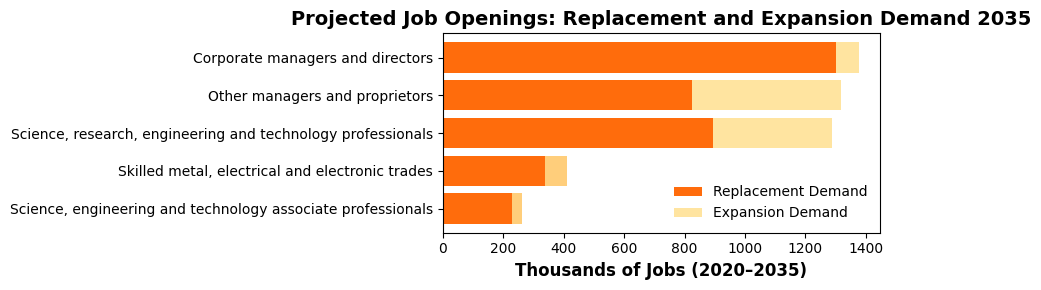

In [42]:
plot_demand_vs_requirement_stacked(df, show_codes=["21", "31", "52", "11", "12"])